uid: 14.0
cities in uid
[2, 11, 126, 130, 133, 188, 197, 217, 243, 319, 321, 363, 406, 455, 463, 473, 513, 526, 588, 667, 669, 673, 677, 797, 883, 903, 941, 983, 1012, 1018, 1067, 1089, 1181, 1216, 1253, 1288, 1298, 1337, 1365, 1371, 1422, 1578, 1620, 1652, 1656, 1697, 1712, 1718, 1824]
[(array([737]), array([3082])), (array([790]), array([3245])), (array([755]), array([3068])), (array([761]), array([3123])), (array([757]), array([3130])), (array([808]), array([3070])), (array([772]), array([3181])), (array([801]), array([3087])), (array([753]), array([3095])), (array([776]), array([3152])), (array([731]), array([3093])), (array([775]), array([3140])), (array([767]), array([3094])), (array([779]), array([3068])), (array([738]), array([3113])), (array([765]), array([3261])), (array([745]), array([3097])), (array([732]), array([3106])), (array([787]), array([3222])), (array([714]), array([3097])), (array([757]), array([3159])), (array([759]), array([3220])), (array([719]), array([3091]))

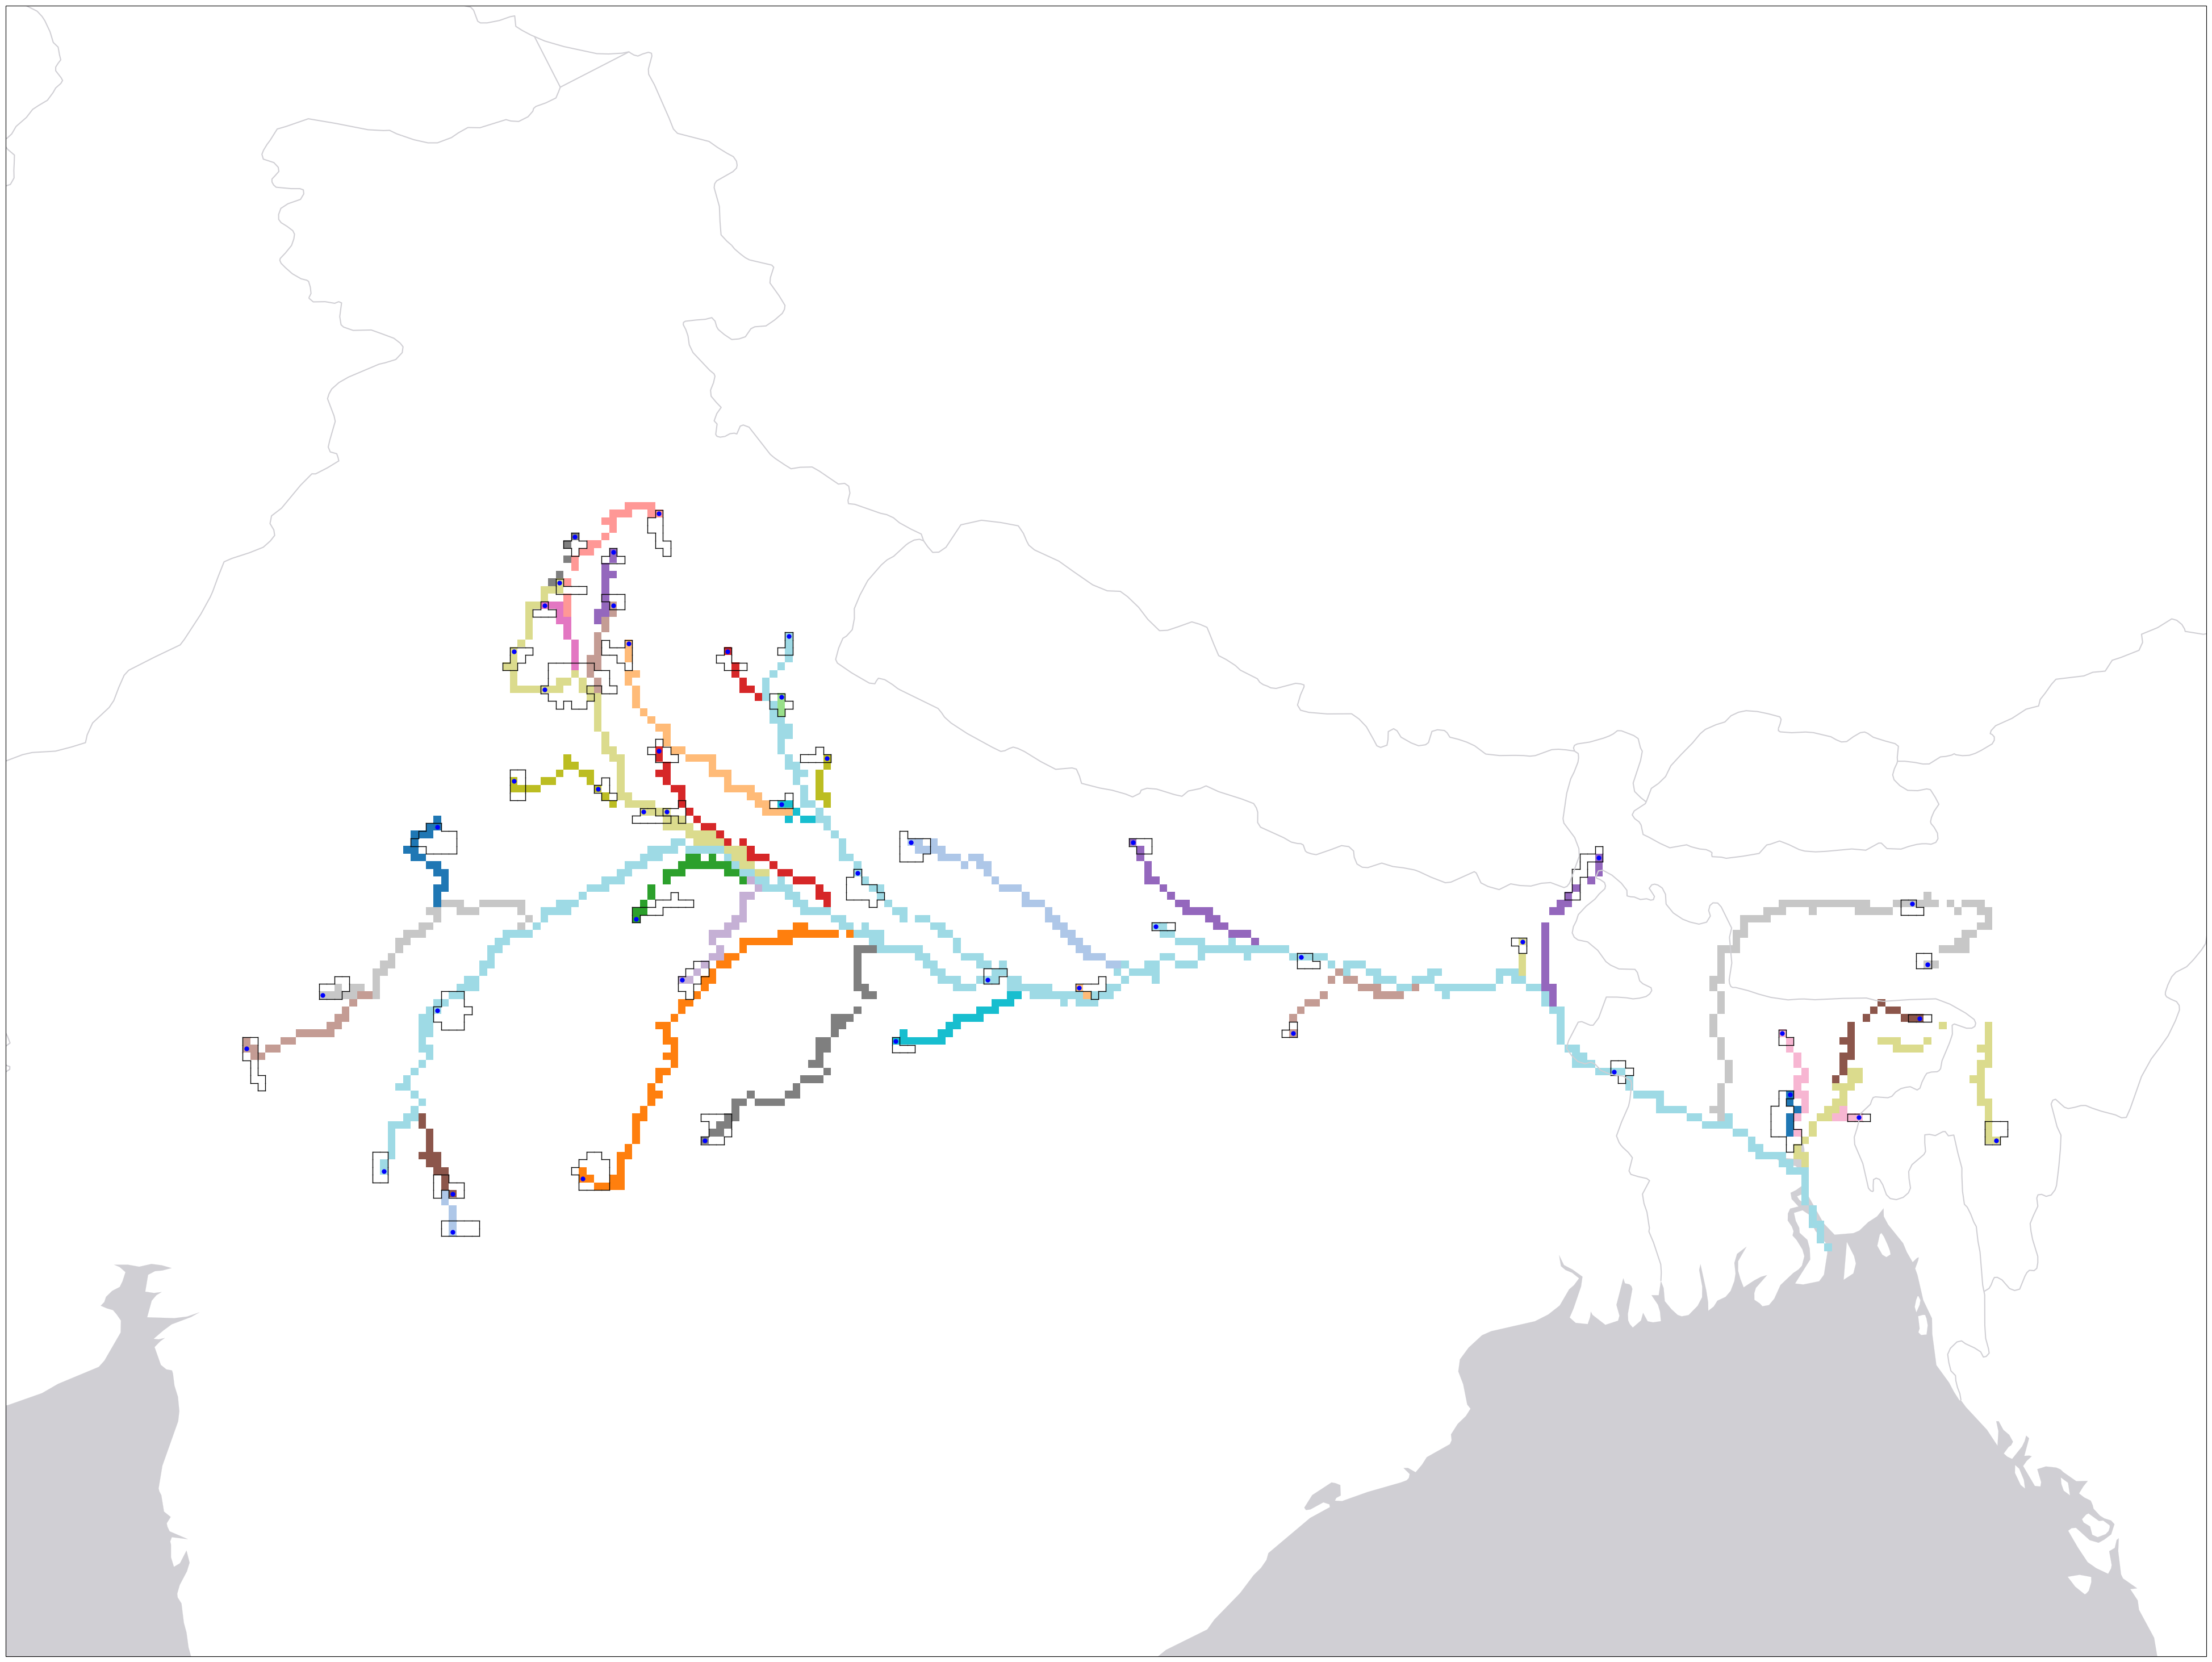

In [18]:
# すごい時間かかります
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped

def updown(new_basin_to_cities, key_index=0):
    # get uid and city list
    keys_list = list(new_basin_to_cities.keys())
    uid = keys_list[key_index]
    print(f'uid: {uid}')
    rivnum_list = new_basin_to_cities[uid]
    rivnum_list = [int(i) for i in rivnum_list]
    
    # remove overlap
    prf_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/cty_prf_'
    rivnum_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)
    rivnxl_path = f"/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)
    overlap_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    rivnum_list_removed = [num for num in rivnum_list if num not in numbers]
    rivnum_list_removed = [int(i) for i in rivnum_list_removed]
    print('cities in uid')
    print(rivnum_list_removed)
    
    # coord of purficication
    coords_a = []
    for city_num in rivnum_list_removed:
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        uid = int(float(uid))
        prf_coord = np.where((prf == 1) & (rivnum_gl5 == uid))
        coords_a.append(prf_coord)
    print(coords_a)
    
    # down??
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    for cid in range(len(coords_a)):
        visited_coords = set()
        riv_path_array[coords_a[cid][0][0], coords_a[cid][1][0]] = cid
        
        coords_b = coords_a.copy()
        coords_b.pop(cid) 
        cind_list = rivnum_list_removed.copy()
        cind_list.pop(cid)
        
        if len(coords_a) > 0:
            target_coord = (coords_a[cid][0][0], coords_a[cid][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = cid
                target_coord = next_coord
        
        for cind, coord in enumerate(coords_b):
            standard_coord = (coord[0][0], coord[1][0])
            if standard_coord in visited_coords:
                #print(f"upstream: city{rivnum_list_removed[cid]}, downstream: city{cind_list[cind]}")
                edges.append((rivnum_list_removed[cid], cind_list[cind]))
            #else:
                #print("no city in downstream")

    # edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
    return edges, riv_path_array, coords_a, rivnum_list_removed

def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def main():
    #
    msk_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)
    #
    key_index = 1
    left = 71
    right = 95
    bottom = 18
    top = 36
    #
    resolution=12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    extent = (-180, 180, -90, 90)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    
    projection = ccrs.PlateCarree(central_longitude=0)
    fig, ax = plt.subplots(figsize=(50,50), subplot_kw={'projection': projection})
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#d0cfd4')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4')
    ax.gridlines(visible=False)
    
    ###########################################################################################
    edges, riv_path_array, coords_a, rivnum_list_removed = updown(new_basin_to_cities, key_index=key_index)
    tmp = np.ma.masked_where(riv_path_array == 0, riv_path_array)
    im = ax.imshow(tmp, extent=extent, transform=ccrs.PlateCarree(), cmap='tab20')
    ###########################################################################################
    
    for city_num in rivnum_list_removed:
        ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
        mask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        draw_mask_sotowaku(extent, mask, ax=ax, sotowaku_color='black', linewidth=1)
    
    def grid_to_latlon(row, col, extent):
        delta = 360/4320
        x_left, y_top = extent[0], extent[3]
        lon = x_left + (col+0.5) * delta
        lat = y_top - (row+0.5) * delta
        return lon, lat
    latlon_coords = [grid_to_latlon(row[0], col[0], extent) for row, col in coords_a]
    for lon, lat in latlon_coords:
        ax.plot(lon, lat, marker='o', color='blue', markersize=5, transform=ccrs.PlateCarree())
    
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    
    plt.show()

main()